# Initialize Datasets
## Places

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import json
from tqdm import tqdm

### Dataset Parameters

In [2]:
# ds_path = "../../data/places_dump_US.geojson"
ds_path = "/scratch1/ukumaras/datasets/places_o200000_q5000000_scaled.json"
output_dir = "/scratch1/ukumaras/datasets/exported/"

num_objects = 1000000
num_queries = 1000000

shuffle = True
should_scale = True
grid_range = 512
query_span = 0.10
spatial_uni = False
fixed_max_keywords = True
min_keywords = 1
max_keywords = 7
random_limited_query_span = True

seed = 7

### Load Data

In [3]:
content = []

with open(ds_path, "r") as f:
    for i, line in tqdm(enumerate(f)):
        if (len(content) >= num_objects + num_queries):
            break

        place = json.loads(line)            
        content.append(place)

df = pd.DataFrame(content)
if shuffle:
    df = df.sample(frac=1).drop(columns=['id']).reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
df.head()

2000000it [00:12, 162906.22it/s]


,id,x,y,keywords,scaled
0,0,229.214331,178.869172,"[counselor, marriage, family]",True
1,1,315.092996,205.295414,[alteration],True
2,2,423.050493,145.959489,[design],True
3,3,229.587163,171.313404,[laboratory],True
4,4,255.643006,148.981055,[painter],True


### Pre-process

In [4]:
def scale(c, minc, maxc):
    return (c - minc) * grid_range / (maxc - minc)


if should_scale and not spatial_uni:
    minx = df['x'].min()
    miny = df['y'].min()
    maxx = df['x'].max()
    maxy = df['y'].max()
    
    df['x'] = df['x'].apply(lambda x: scale(x, minx, maxx))
    df['y'] = df['y'].apply(lambda y: scale(y, miny, maxy))
    df['scaled'] = True

df.head()

,id,x,y,keywords,scaled
0,0,240.853890,139.756528,"[counselor, marriage, family]",True
1,1,331.093495,169.285455,[alteration],True
2,2,444.533100,102.982944,[design],True
3,3,241.245655,131.313644,[laboratory],True
4,4,268.624620,106.359270,[painter],True


### Uniform Sample

In [5]:
if spatial_uni:
    sample = pd.DataFrame(np.random.uniform(0, 512, (num_objects + num_queries, 2)), columns=['x', 'y'])
    
    df['x'] = sample['x']
    df['y'] = sample['y']

df.head()

,id,x,y,keywords,scaled
0,0,240.853890,139.756528,"[counselor, marriage, family]",True
1,1,331.093495,169.285455,[alteration],True
2,2,444.533100,102.982944,[design],True
3,3,241.245655,131.313644,[laboratory],True
4,4,268.624620,106.359270,[painter],True


In [6]:
if fixed_max_keywords:
    import random

    def clamp_keywords(keywords):
        if (len(keywords) < max_keywords):
            return keywords
        return sorted(random.sample(keywords, max_keywords))
    df['keywords'] = df['keywords'].apply(clamp_keywords)

df.head()

,id,x,y,keywords,scaled
0,0,240.853890,139.756528,"[counselor, marriage, family]",True
1,1,331.093495,169.285455,[alteration],True
2,2,444.533100,102.982944,[design],True
3,3,241.245655,131.313644,[laboratory],True
4,4,268.624620,106.359270,[painter],True


In [7]:
df['keywords'] = df['keywords'].apply(sorted)
df.head()

,id,x,y,keywords,scaled
0,0,240.853890,139.756528,"[counselor, family, marriage]",True
1,1,331.093495,169.285455,[alteration],True
2,2,444.533100,102.982944,[design],True
3,3,241.245655,131.313644,[laboratory],True
4,4,268.624620,106.359270,[painter],True


### Visualize

<Axes: xlabel='x', ylabel='y'>

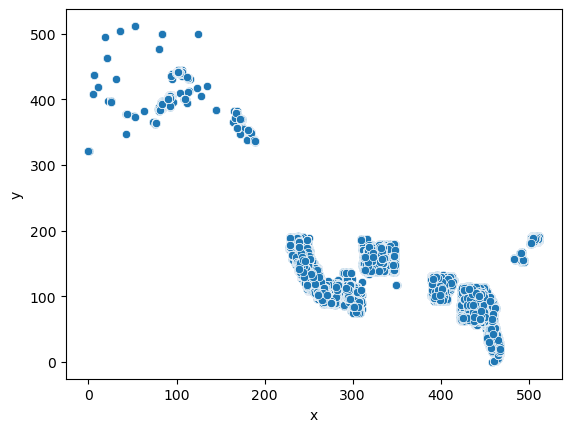

In [8]:
sns.scatterplot(x="x", y="y", data=df.loc[:, ["x", "y"]])

### Export

In [9]:
# fail

In [10]:
output_name = f'{output_dir}places_o{num_objects}_q{num_queries}'

if (should_scale and not spatial_uni):
    output_name += f'_scaled'

if (spatial_uni):
    output_name += f'_spatialuni'

if (min_keywords != 0):
    output_name += f'_minkeys' + str(min_keywords)

if fixed_max_keywords:
    output_name += f'_maxkeys' + str(max_keywords)

if random_limited_query_span:
    output_name += f'_varspan'

if shuffle:
    output_name += f'_shuffled'

In [11]:
rng = np.random.default_rng()

step = grid_range * query_span
q_df = df.iloc[:num_objects, :].copy()

if random_limited_query_span:
    q_df['step'] = [step * rng.random() for _ in range(q_df.shape[0])]
else:
    q_df['step'] = [step for _ in range(q_df.shape[0])]

q_df['min_x'] = (q_df['x'] - q_df['step']).clip(0, 512)
q_df['min_y'] = (q_df['y'] - q_df['step']).clip(0, 512)
q_df['max_x'] = (q_df['x'] + q_df['step']).clip(0, 512)
q_df['max_y'] = (q_df['y'] + q_df['step']).clip(0, 512)

q_df['et'] = num_queries + num_objects

q_df.head()

,id,x,y,keywords,scaled,step,min_x,min_y,max_x,max_y,et
0,0,240.853890,139.756528,"[counselor, family, marriage]",True,10.453174,230.400716,129.303354,251.307065,150.209703,2000000
1,1,331.093495,169.285455,[alteration],True,39.853749,291.239746,129.431706,370.947244,209.139204,2000000
2,2,444.533100,102.982944,[design],True,24.126728,420.406372,78.856216,468.659829,127.109673,2000000
3,3,241.245655,131.313644,[laboratory],True,47.190638,194.055017,84.123006,288.436293,178.504282,2000000
4,4,268.624620,106.359270,[painter],True,12.805196,255.819424,93.554074,281.429816,119.164466,2000000


In [12]:
q_df.to_json(f'{output_name}_queries.jsonl', orient='records', lines=True)
print(f'{output_name}_queries.jsonl')

/scratch1/ukumaras/datasets/exported/places_o1000000_q1000000_scaled_minkeys1_maxkeys7_varspan_shuffled_queries.jsonl


In [13]:
df.iloc[num_objects:num_objects+num_queries, :].to_json(f'{output_name}_objects.jsonl', orient='records', lines=True)
print(f'{output_name}_objects.jsonl')

/scratch1/ukumaras/datasets/exported/places_o1000000_q1000000_scaled_minkeys1_maxkeys7_varspan_shuffled_objects.jsonl


In [14]:
df.shape

(2000000, 5)